In [6]:
import logging
import warnings
import re
import argparse
import yaml

import pandas as pd

from src.ingest import *
from src.aggregate import *
from src.preprocess import *
from src.hypertune import *
from src.train import *
import os
import yaml

# A. Baseline Scenario: No Promotion Plan

In [ ]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\pred_2025_data\no_promo").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

# imputation for necessary columns:
org_df["Promo_Type"] = org_df["Promo_Type"].fillna("No_Promo")
org_df["Budget_USD"] = org_df["Budget_USD"].fillna(0)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Hyperparameter tuning
model_name = "lstm_2025"
tuner = HyperTuner(model_name, n_features=60, ts_splits=5)
feats = tuner.run_permutation_importance(nn_X_tr, nn_y_tr)
mandatory = [
    c for c in nn_X_tr.columns
    if re.match(r"(?i)(month|quarter|year)", c)
]
feats = list(dict.fromkeys(feats + mandatory))
tuner.tune(n_trials=100)

with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer.fit(nn_X_tr[feats], nn_y_tr)
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

[I 2025-05-28 08:38:19,903] A new study created in memory with name: no-name-921f9071-2596-48bc-bc6e-1e7c34b0ab83


Selected features for lstm_2025: ['Promo_Type_No_Promo', 'Quarter_3', 'New_Sales_lag_12', 'Quarter_4', 'Month_10', 'Month_3', 'Month_7', 'Month_8', 'Month_4', 'Month_11', 'Month_12', 'Month_2', 'Month_6', 'Promo_Type_Discount', 'Month_9', 'Promo_Type_Cashback', 'Year', 'Budget_USD', 'Month_5', 'Quarter_2', 'New_Sales_lag_15']


[I 2025-05-28 08:38:23,129] Trial 0 finished with value: 0.006092106950752768 and parameters: {'lr': 0.009499965757423928, 'units': 112, 'batch_size': 16, 'patience': 10}. Best is trial 0 with value: 0.006092106950752768.
[I 2025-05-28 08:38:25,363] Trial 1 finished with value: 0.007495300607346351 and parameters: {'lr': 0.009475684537721034, 'units': 96, 'batch_size': 16, 'patience': 10}. Best is trial 0 with value: 0.006092106950752768.
[I 2025-05-28 08:38:26,756] Trial 2 finished with value: 0.009405217492718214 and parameters: {'lr': 0.007116641808415799, 'units': 128, 'batch_size': 32, 'patience': 10}. Best is trial 0 with value: 0.006092106950752768.
[I 2025-05-28 08:38:28,182] Trial 3 finished with value: 0.019749889440988697 and parameters: {'lr': 0.009148187256059396, 'units': 96, 'batch_size': 32, 'patience': 12}. Best is trial 0 with value: 0.006092106950752768.
[I 2025-05-28 08:38:30,349] Trial 4 finished with value: 0.005668677445635939 and parameters: {'lr': 0.00760457347

Best params for lstm_2025: {'lr': 0.007671352785077888, 'units': 96, 'batch_size': 32, 'patience': 8}
NUMBER OF FINAL FEATURES FOR LSTM_2025: 21
Epoch 1/50
11/11 [==============================] - 1s 18ms/step - loss: 0.0230 - val_loss: 0.0485
Epoch 2/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 3/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0104
Epoch 4/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0118
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0075
Epoch 6/50
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 7/50
11/11 [==============================] - 0s 4ms/step - loss: 9.2602e-04 - val_loss: 0.0106
Epoch 8/50
11/11 [==============================] - 0s 4ms/step - loss: 8.6737e-04 - val_loss: 0.0085
Epoch 9/50
11/11 [==============================] - 0s 4ms/ste

  0%|          | 0/360 [00:00<?, ?it/s]

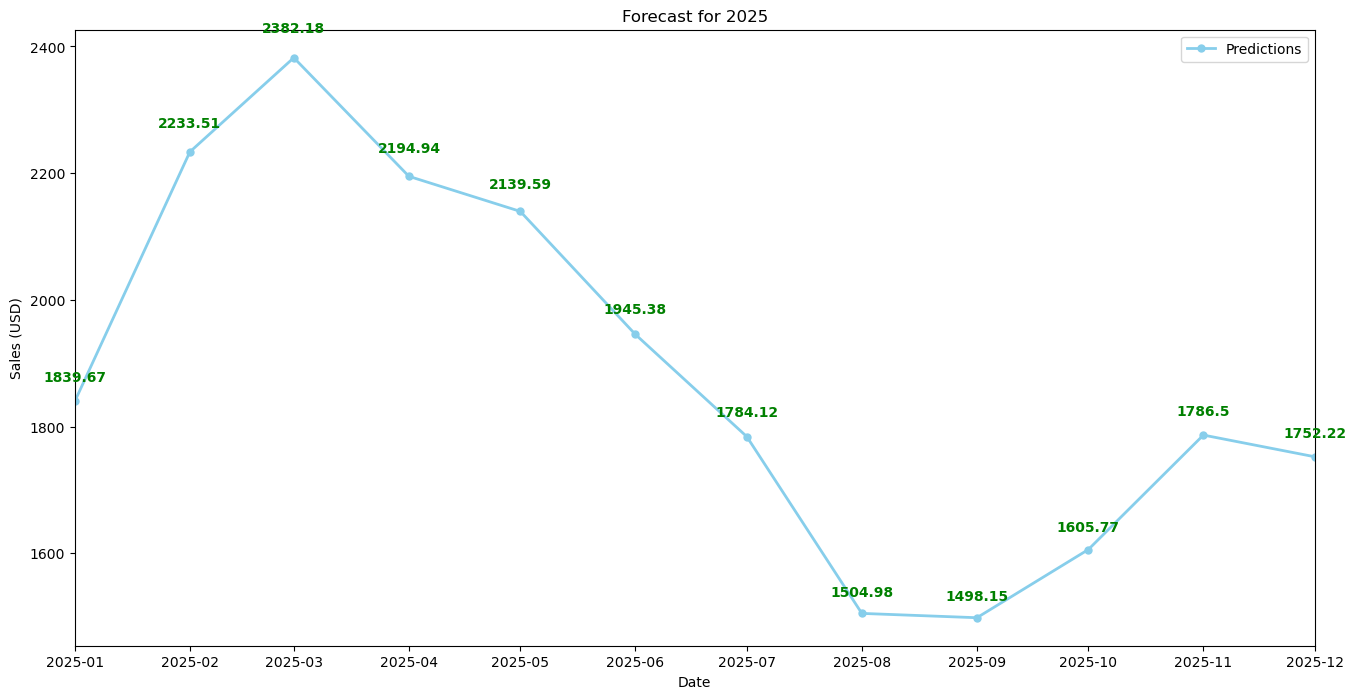

In [8]:
# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

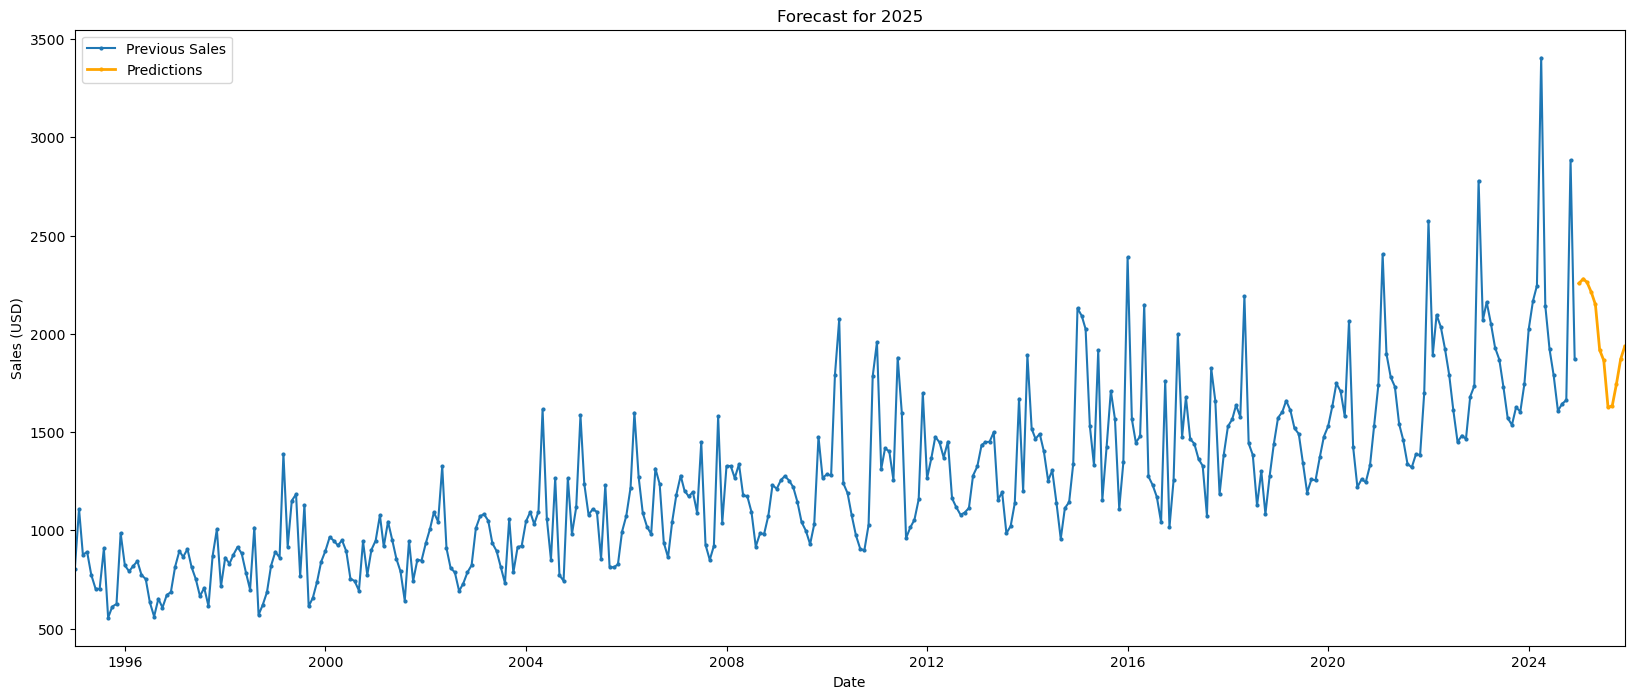

In [4]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

# B. 1st Scenario: Forecasting With Promotion Plan 2025

In [ ]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\pred_2025_data\with_promo_scen1").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

# imputation for necessary columns:
org_df["Promo_Type"] = org_df["Promo_Type"].fillna("No_Promo")
org_df["Budget_USD"] = org_df["Budget_USD"].fillna(0)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Load hypertuned results (features shortlisted & hyperparameters)
with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

model_name = "lstm_2025"
if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    feats = results["results"][model_name]["features"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer._load()
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    # trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

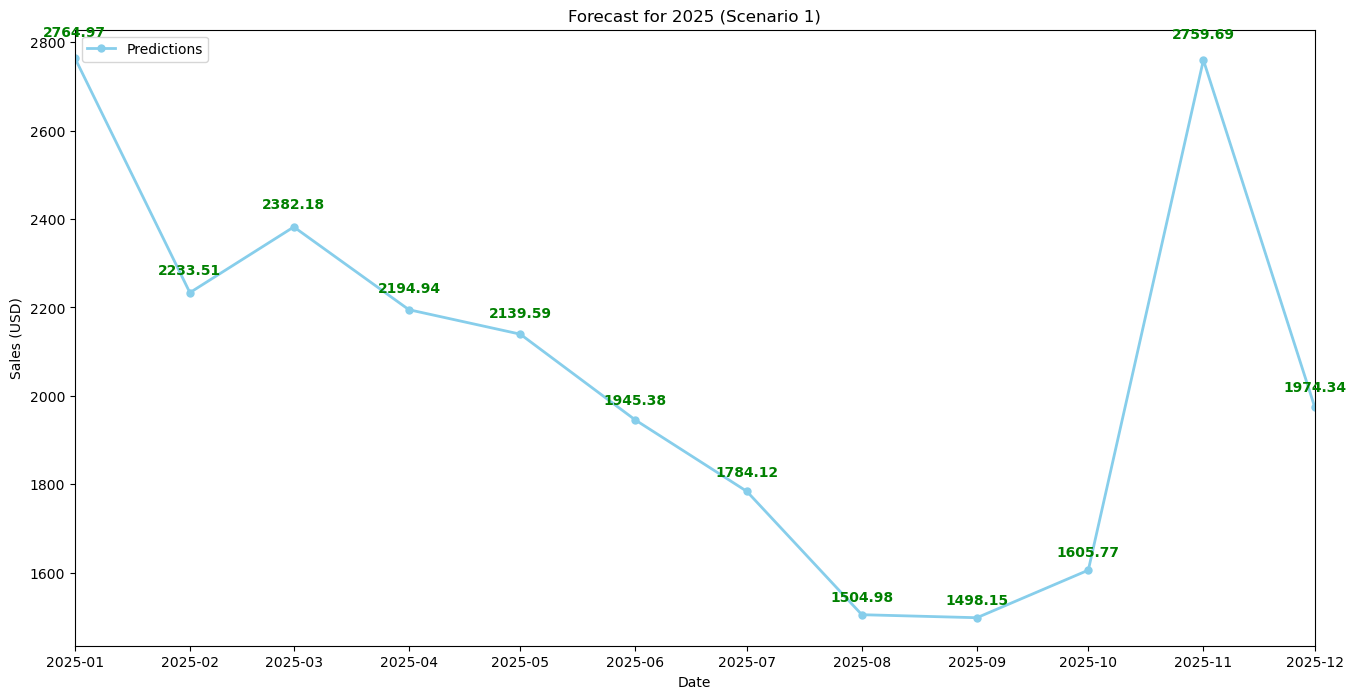

In [26]:
sales_prediction = pd.DataFrame(preds, index=nn_X_te.index, columns=["Sales"])
OUTPUT_DIR = "./models/lstm_2025_evaluation/"

sales_prediction.to_csv(os.path.join(OUTPUT_DIR, "sales_prediction_promo_scen1.csv"))

# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025 (Scenario 1)")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

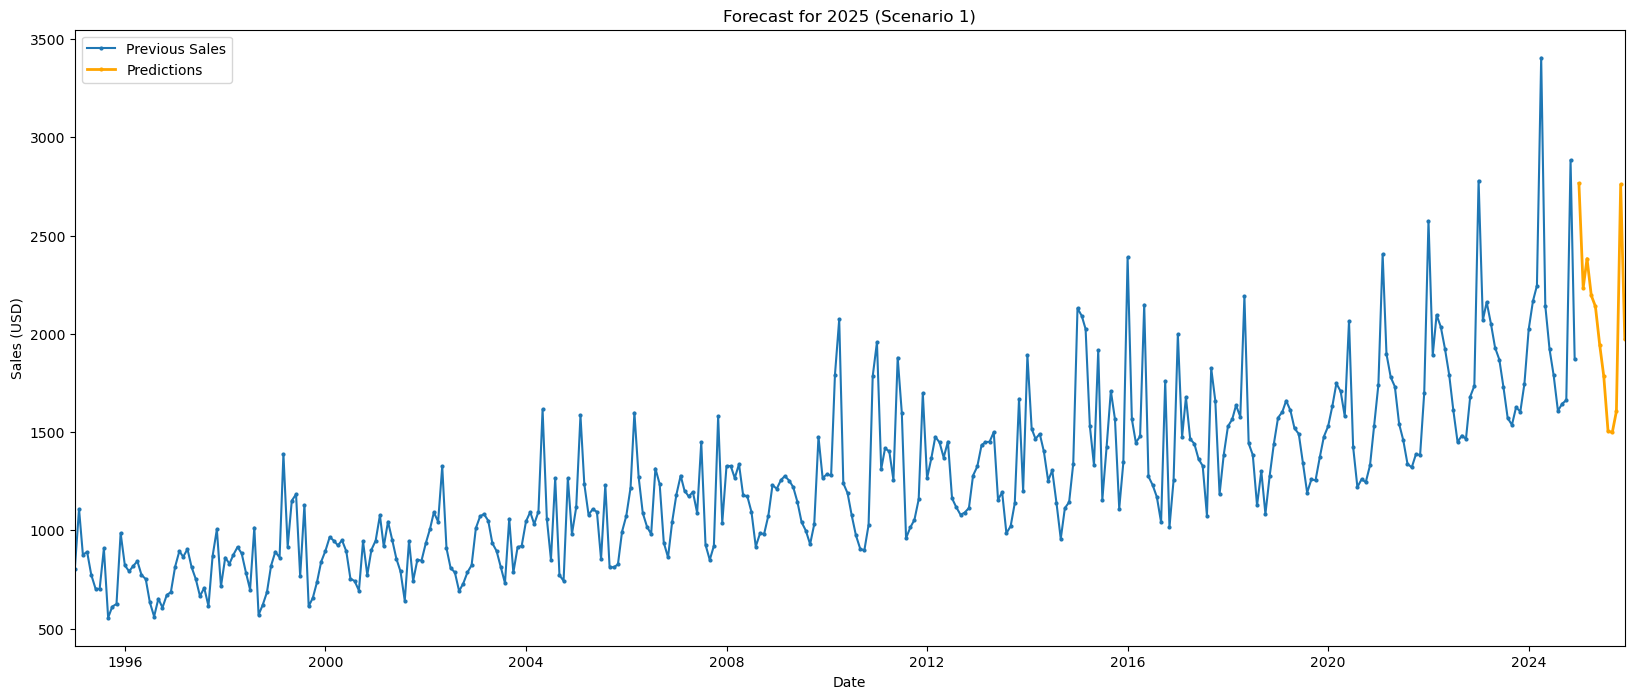

In [27]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025 (Scenario 1)")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

# C. 2nd Scenario: Forecasting With Promotion Plan 2025

In [ ]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\pred_2025_data\with_promo_scen2").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

# imputation for necessary columns:
org_df["Promo_Type"] = org_df["Promo_Type"].fillna("No_Promo")
org_df["Budget_USD"] = org_df["Budget_USD"].fillna(0)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Load hypertuned results (features shortlisted & hyperparameters)
with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

model_name = "lstm_2025"
if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    feats = results["results"][model_name]["features"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer._load()
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    # trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

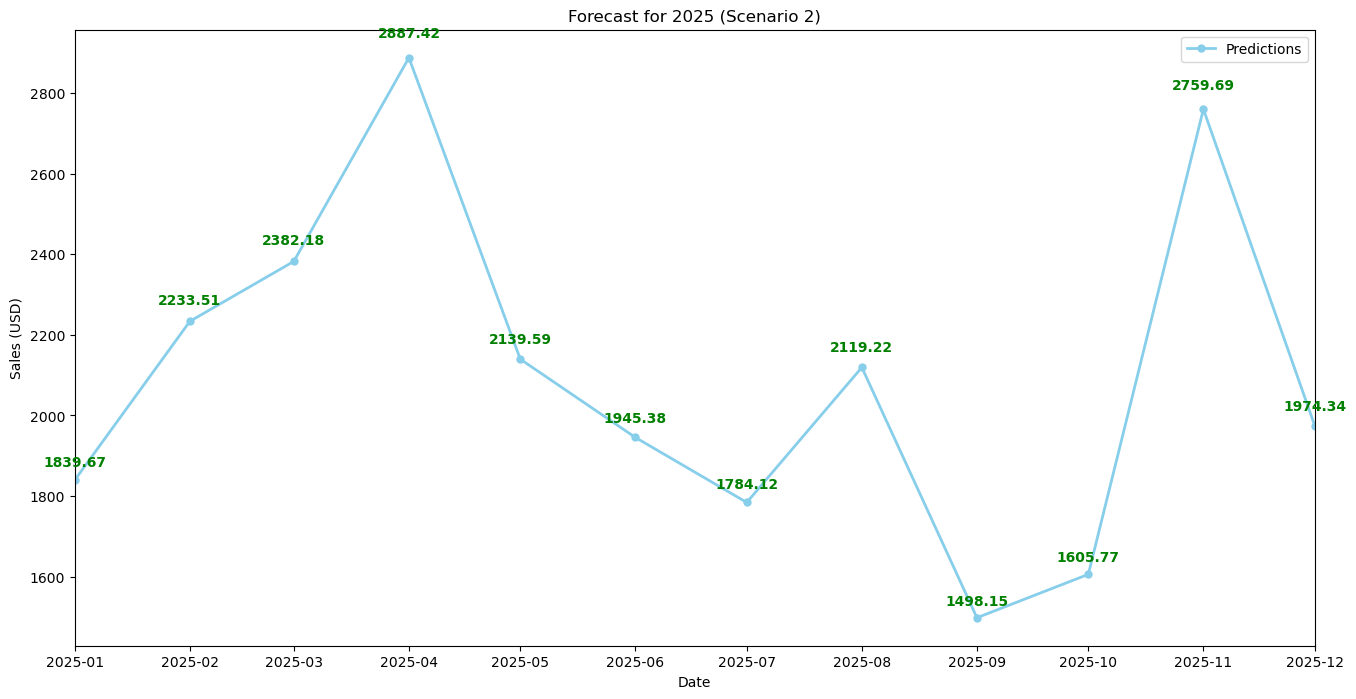

In [29]:
sales_prediction = pd.DataFrame(preds, index=nn_X_te.index, columns=["Sales"])
OUTPUT_DIR = "./models/lstm_2025_evaluation/"

sales_prediction.to_csv(os.path.join(OUTPUT_DIR, "sales_prediction_promo_scen2.csv"))

# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025 (Scenario 2)")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

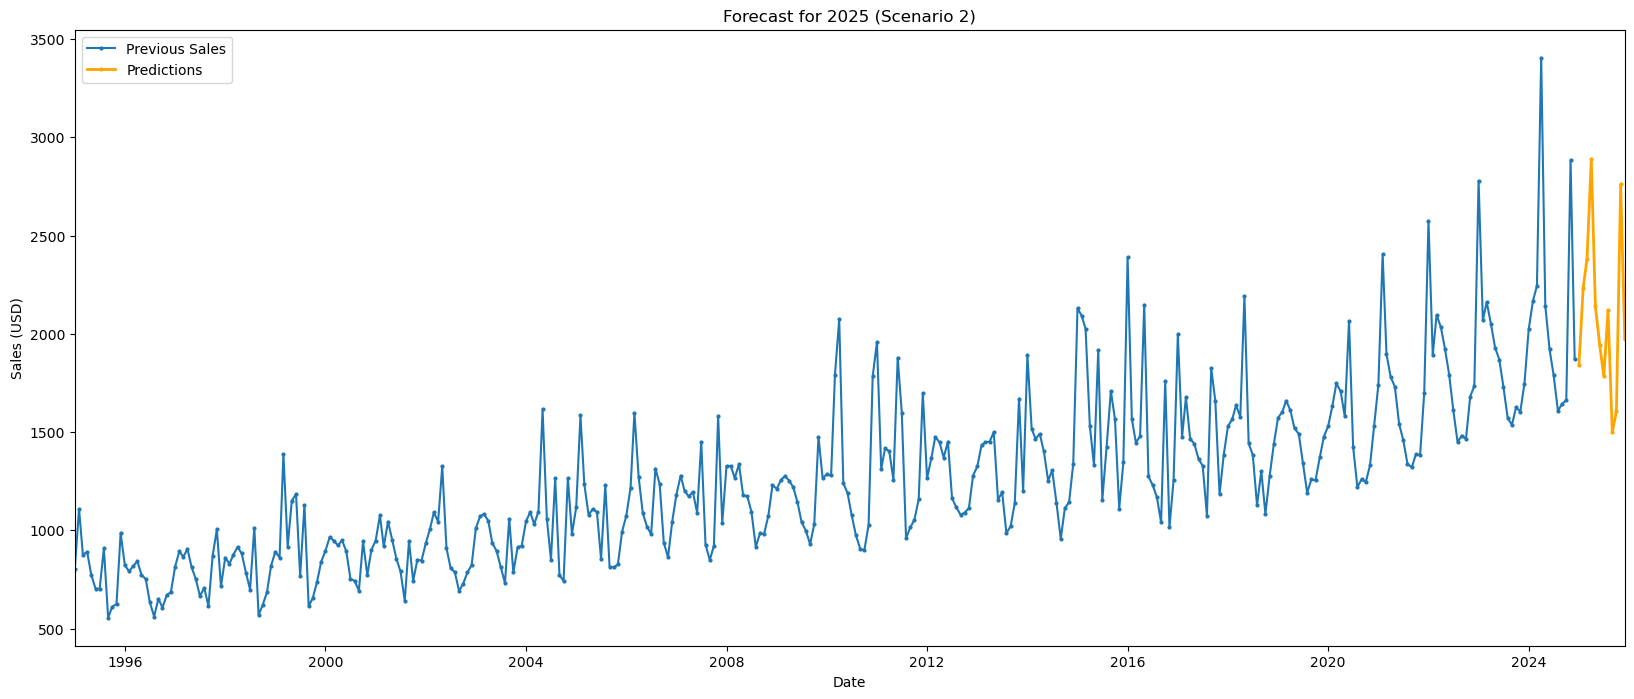

In [30]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025 (Scenario 2)")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

# D. 3rd Scenario: Forecasting With Promotion Plan 2025

In [ ]:
data_dict = Ingestion(org_path=r"D:\Study\UNIVERSITY\THIRD YEAR\Business Analytics\ASSIGNMENT 1_ Sales Data Analysis\pred_2025_data\with_promo_scen3").load_data()
agg = Aggregation(data_dict, required_shiftback=12)
merged = agg.merge_data()

org_df = merged[agg.org_cols]
lag_ws = [12, 15]
org_df = generate_lagged_feats(org_df, ["New_Sales"], lag_ws)
org_df["Month"] = org_df.index.month.astype(str)
org_df["Year"] = org_df.index.year
org_df["Quarter"] = org_df.index.quarter.astype(str)

# imputation for necessary columns:
org_df["Promo_Type"] = org_df["Promo_Type"].fillna("No_Promo")
org_df["Budget_USD"] = org_df["Budget_USD"].fillna(0)

nn_X_tr, nn_y_tr, nn_X_te, nn_y_te = agg.split_train_test(org_df, target_feat="New_Sales")

# Preprocess
nn_preprocessor = CustomPreprocessor()
nn_preprocessor.fit(nn_X_tr, nn_y_tr, mi_pct = 0.0)
nn_X_tr = nn_preprocessor.transform(nn_X_tr)
nn_X_te = nn_preprocessor.transform(nn_X_te)

# Load hypertuned results (features shortlisted & hyperparameters)
with open("./src/hypertune_results.yaml", "r") as f:
    results = yaml.safe_load(f)

model_name = "lstm_2025"
if model_name in results.get("results", {}) and "params" in results["results"][model_name]:
    model_params = results["results"][model_name]["params"]
    feats = results["results"][model_name]["features"]
    print(f"NUMBER OF FINAL FEATURES FOR {model_name.upper()}: {len(feats)}")

    trainer = ModelTrainer(model_name, params=model_params)
    trainer._load()
    trainer.model.summary()
    preds = trainer.predict(nn_X_te[feats])
    # trainer.generate_shap_plot(X_train=nn_X_tr[feats], save=True)

Original frequency: MS
Converted format: period[M]
Original frequency: None
Converted format: period[M]
Original frequency: YS-JAN

=== Initial DataFrame ===
Columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']
Dtypes:
Promo_Type           object
Budget_USD          float64
New_Sales_lag_12    float64
New_Sales_lag_15    float64
Month                object
Year                  int32
Quarter              object
dtype: object

=== After dropna ===
Remaining columns: ['Promo_Type', 'Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Month', 'Year', 'Quarter']

=== Cycle features ===
[]

=== Numerical features ===
Count: 4
First 10: ['Budget_USD', 'New_Sales_lag_12', 'New_Sales_lag_15', 'Year']

=== Categorical features ===
Count: 3
['Promo_Type', 'Month', 'Quarter']
╒══════════════════╤═════════════╕
│                  │          MI │
╞══════════════════╪═════════════╡
│ Budget_USD       │ 2.22045e-16 │
├──────────────────┼─────────

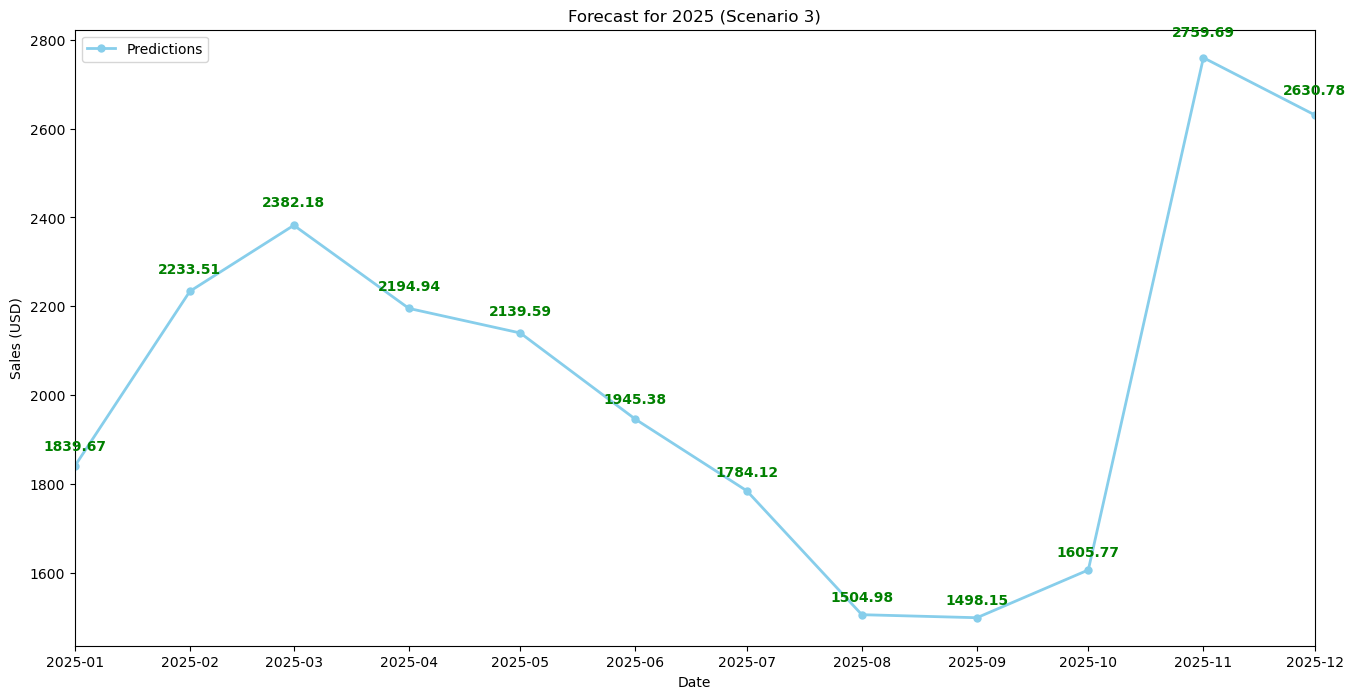

In [32]:
sales_prediction = pd.DataFrame(preds, index=nn_X_te.index, columns=["Sales"])
OUTPUT_DIR = "./models/lstm_2025_evaluation/"

sales_prediction.to_csv(os.path.join(OUTPUT_DIR, "sales_prediction_promo_scen3.csv"))

# plot preds for 2025
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(nn_X_te.index, preds, marker="o", markersize=5, color = "skyblue", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025 (Scenario 3)")
ax.set_xlim(nn_X_te.index.min(), nn_X_te.index.max())
ax.legend(["Predictions"])
for i in range(len(nn_X_te.index)):
    ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')

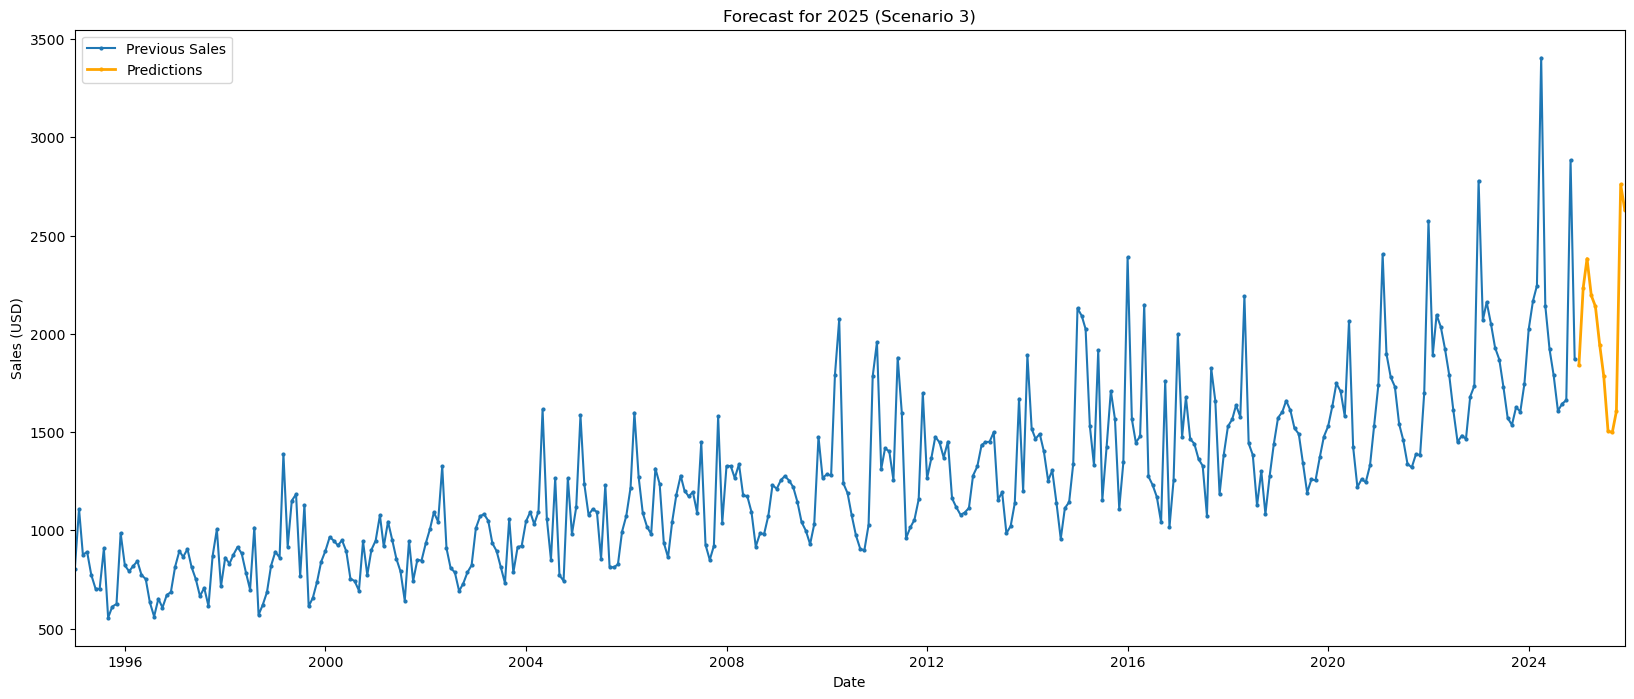

In [33]:
# plot 2025 along with prev years sales
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(nn_X_tr.index, nn_y_tr, marker="o", markersize=2)
ax.plot(nn_X_te.index, preds, marker="o", markersize=2, color = "orange", linewidth=2)
ax.set_xlabel("Date")
ax.set_ylabel("Sales (USD)")
ax.set_title("Forecast for 2025 (Scenario 3)")
ax.set_xlim(nn_X_tr.index.min(), nn_X_te.index.max())
ax.legend(["Previous Sales", "Predictions"])
# for i in range(len(nn_X_te.index)):
#     ax.text(nn_X_te.index[i], preds[i]+preds[i]*0.015, str(round(preds[i], 2)), ha='center', va='bottom', fontsize=10, color='green', weight='bold')